### The Auto MPG dataset

> The dataset is available from [UCI Machine Learning Repository.](https://archive.ics.uci.edu/ml/index.php)

### Impots

In [4]:
import numpy as np
import torch
from torch.nn import functional as f
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

### Data Prep
> Creating a Car Dataset

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names, na_values='?'
                         , comment='\t', sep=' ', skipinitialspace=True)

In [3]:
raw_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [5]:
raw_dataset.isnull().values.any()

True

In [6]:
df = raw_dataset.dropna()
df.isnull().values.any()

False

In [16]:
column_names[1:]

['Cylinders',
 'Displacement',
 'Horsepower',
 'Weight',
 'Acceleration',
 'Model Year',
 'Origin']

> We may also want to make transformation on the dataset. Although all the data is numeric we may want to scale the data. We are going to use `scikit-learn` `MinMaxScaler` to scale other columns exept for the `MPG` which is what we are trying to predict.

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [23]:
class Car(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        self.column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
        self.dataframe = pd.read_csv(path, names=column_names, na_values='?'
                         , comment='\t', sep=' ', skipinitialspace=True)
        if self.dataframe.isnull().values.any():
            self.dataframe = self.dataframe.dropna()
        
        self.y = self.dataframe["MPG"].values.astype('float32')
        self.features = self.dataframe.drop(["MPG"], axis=1)
        
        self.column_transformer = ColumnTransformer([
                ('min_max_scaler', MinMaxScaler(), self.column_names[1:])
        ]).fit(self.features)
        
        self.x = self.column_transformer.transform(self.features).astype('float32')
        self.len = self.y.shape[0]
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        if self.transform:
            sample = self.transform(sample)
        return sample

> Creating a `ToTensor` transformer

In [24]:
class ToTensor:
    def __call__(self, samples):
        x, y = samples
        return torch.Tensor(x), torch.Tensor(np.array(y))
        

In [25]:
car = Car(path=url, transform=ToTensor())

In [27]:
car[1]

(tensor([1.0000, 0.7287, 0.6467, 0.5897, 0.2083, 0.0000, 0.0000]), tensor(15.))

> Split the data into ``train`` and ``test`` sets

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train, test = train_test_split(car, test_size=.10, random_state=42)

In [39]:
train[0][0].shape

torch.Size([7])

> Creating Data ``Loaders``

In [36]:
train_set = DataLoader(
    train,
    shuffle=True,
    batch_size=10,
)
test_set = DataLoader(
    test,
    shuffle=False,
    batch_size=10,
)

### Creating a `F-FNN` for this regression problem

In [41]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=7, out_features = 64)
        self.fc2 = nn.Linear(in_features=64, out_features = 128)
        self.fc3 = nn.Linear(in_features=128, out_features = 256)
        self.fc4 = nn.Linear(in_features=256, out_features = 128)
        self.fc5 = nn.Linear(in_features=128, out_features = 64)
        self.fc6 = nn.Linear(in_features=64, out_features = 16)
        self.fc7 = nn.Linear(in_features=16, out_features = 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.fc7(x)
        return x
    
net = Net()
net

Net(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=16, bias=True)
  (fc7): Linear(in_features=16, out_features=1, bias=True)
)

In [42]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = nn.L1Loss()

In [60]:
EPOCHS = 100
losses = []
for epoch in range(EPOCHS):
    for X, y in train_set:
        optimizer.zero_grad()
        # forward pass
        outputs = net(X)
        # loss 
        loss = criterion(outputs, y.unsqueeze_(1))
        # backward pass
        loss.backward()
        # update the weights
        optimizer.step()
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epochs: {epoch+1}/{EPOCHS}, loss={loss.item():.3f}')
        

Epochs: 10/100, loss=2.149
Epochs: 20/100, loss=0.679
Epochs: 30/100, loss=3.116
Epochs: 40/100, loss=3.591
Epochs: 50/100, loss=1.659
Epochs: 60/100, loss=2.106
Epochs: 70/100, loss=8.026
Epochs: 80/100, loss=5.385
Epochs: 90/100, loss=2.702
Epochs: 100/100, loss=4.502


> Visualising the ``model`` ``loss`` on each ``epoch``

In [61]:
epochs = np.arange(EPOCHS)
losses = np.array(losses)
len(losses), len(losses)

(100, 100)

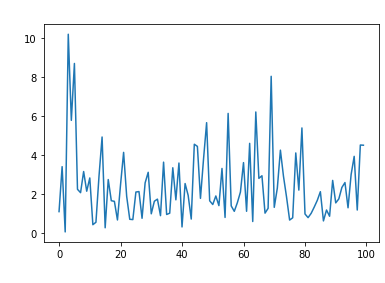

In [64]:
plt.plot(epochs, losses)
plt.title("Loss vrs Epochs", fontsize=16, color='white')
plt.xlabel("Epochs", fontsize=12, color='white')
plt.ylabel("Loss", fontsize=12, color='white')
plt.show()

> Evaluating the ``model`` ``on the test_set``

In [49]:
with torch.no_grad():
    for X, y in test_set:
        outputs = net(X)
        # Loss
        loss = criterion(outputs, y.unsqueeze_(1))
    print("Loss: ", loss.item())

Loss:  2.3932158946990967


### Making predictions

In [66]:
for X, y in test_set:
    pass

In [67]:
net(X[:5]), y[:5]

(tensor([[11.7456],
         [20.8196],
         [18.4417],
         [29.8237],
         [10.6634]], grad_fn=<AddmmBackward>),
 tensor([15.0000, 19.4000, 19.2000, 31.6000, 13.0000]))

> I'm just happy with the model perfomance especially on predictions